In [1]:
exec(open('make_datasets.py').read())
exec(open('transform_pix.py').read())

数据集拆分和封装完成，metadata.jsonl 文件已生成。


libpng warning: iCCP: known incorrect sRGB profile


In [2]:
import torch
# 配置参数
num_epochs = 50
batch_size = 8
learning_rate = 1e-5
model_id = "../autodl-tmp/runwayml--stable-diffusion/snapshots/f03de327dd89b501a01da37fc5240cf4fdba85a1"
weight_decay = 1e-2
weight_dtype = torch.float16
device = "cuda" if torch.cuda.is_available() else "cpu"
noise_offset = 0.1 # 添加噪声偏移量

print(device)

cuda


In [3]:
from diffusers import StableDiffusionPipeline, DDPMScheduler, AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from peft import get_peft_model, LoraConfig

# 加载 Stable Diffusion 模型
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=weight_dtype).to("cuda")
vae = AutoencoderKL.from_pretrained(
    model_id, subfolder="vae", torch_dtype=weight_dtype
    ).to(device)
unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet", torch_dtype=weight_dtype
    ).to(device)
tokenizer = CLIPTokenizer.from_pretrained(
    model_id, subfolder="tokenizer"
    )
text_encoder = CLIPTextModel.from_pretrained(
    model_id, subfolder="text_encoder", torch_dtype=torch.float16
    ).to(device)
# 设置噪声调度器（用于扩散模型的噪声注入）
noise_scheduler = DDPMScheduler.from_pretrained(
    model_id, subfolder="scheduler"
    )

unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

print(unet)

/root/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [4]:
# 设置 LoRA 配置
lora_config = LoraConfig(
    r=16,  # LoRA 低秩维度
    lora_alpha=32,  # LoRA 融合比例
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],  # LoRA 目标模块微调的目标模块
    init_lora_weights="gaussian"
)

# 添加 LoRA adapter 到模型
model = get_peft_model(unet, lora_config)
model.print_trainable_parameters()
# unet.add_adapter(lora_config)

trainable params: 3,188,736 || all params: 862,709,700 || trainable%: 0.3696


In [5]:
# lora_layers = filter(lambda p: p.requires_grad, unet.parameters())
# print(lora_layers)

In [6]:
# 加载数据集
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./dataset")

print(dataset)

Generating train split: 68 examples [00:00, 1498.71 examples/s]
Generating test split: 17 examples [00:00, 3537.74 examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 68
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 17
    })
})


In [7]:
column_names = dataset["train"].column_names
image_column = column_names[0]
caption_column = column_names[1]

print(f"image column name: {image_column}")
print(f"caption column name: {caption_column}")

image column name: image
caption column name: text


In [8]:
# 图像数据集预处理
from torchvision import transforms
import random
import numpy as np

# 序列化图注
def tokenize_captions(examples, is_train=True):
    captions = []
    for caption in examples[caption_column]:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # 多个标注时随机选择一个
            captions.append(random.choice(caption)
                            if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return inputs.input_ids

# 图像转化
pic_transforms = transforms.Compose([
    transforms.Resize((512, 512)),  # 调整图像大小
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 正则化以符合模型输入要求
])

# 预处理函数
def preprocess(examples):
    images = [image.convert("RGB") for image in examples[image_column]]
    examples["pixel_values"] = [
        pic_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)
    return examples

train_dataset = dataset['train'].with_transform(preprocess)
test_dataset = dataset['test'].with_transform(preprocess)

In [9]:
test_dataset[1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'text': 'a traditional Chinese New Year painting style of a warrior figure, vibrant colors, detailed lines',
 'pixel_values': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1

In [10]:
from torch.utils.data import DataLoader

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"]
                                for example in examples])
    pixel_values = pixel_values.to(
        memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example["input_ids"] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=batch_size,
)

In [11]:
for idx, v in enumerate(train_dataloader):
    if idx == 0:
        print(v)

{'pixel_values': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000

In [12]:
import os
import torch

from tqdm import tqdm
from transformers import AdamW
import matplotlib.pyplot as plt

# 使用 AdamW 优化器
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

# 用于存储每个 epoch 的训练和验证损失
train_losses = []
test_losses = []

# 初始化最小验证损失为一个较大的值
best_loss = float('inf')

# 开始训练
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
        # 将图像转到潜层空间
        pixel = batch["pixel_values"].to(device)
        latents = vae.encode(pixel.to(dtype=weight_dtype)).latent_dist.sample()
        latents = latents * vae.config.scaling_factor

        # 采样噪声
        noise = torch.randn_like(latents)
        if noise_offset:
            noise += noise_offset * torch.randn(
                (latents.shape[0], latents.shape[1], 1, 1), device=latents.device
            )
        
        bsz = latents.shape[0]
        
        # 为每张图采样随机时间步
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device
        ).long()
        
        # 根据噪声在每个时间步的尺度将噪声加到潜层空间
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
        
        # 获取文本嵌入
        tokenized_captions = batch["input_ids"].to(device)
        encoder_hidden_states = text_encoder(tokenized_captions)[0]

        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise
        elif noise_scheduler.config.prediction_type == "v_prediction":
            target = noise_scheduler.get_velocity(
                latents, noise, timesteps)
        else:
            raise ValueError(
                f"Unknown prediction type {noise_scheduler.config.prediction_type}")
        
        # 预测噪声残差并计算损失
        model_pred = model(noisy_latents, timesteps,
                          encoder_hidden_states).sample
        loss = torch.nn.functional.mse_loss(model_pred.float(), target.float(), reduction='mean')
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # 记录每个 epoch 的平均训练损失
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss}")

    # 模型评估
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"Evaluating Epoch {epoch+1}/{num_epochs}"):
            # 将图像转到潜层空间
            pixel = batch["pixel_values"].to(device)
            latents = vae.encode(pixel.to(dtype=weight_dtype)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            # 采样噪声
            noise = torch.randn_like(latents)
            if noise_offset:
                noise += noise_offset * torch.randn(
                    (latents.shape[0], latents.shape[1], 1, 1), device=latents.device
                )
            
            bsz = latents.shape[0]
            
            # 为每张图采样随机时间步
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device
            ).long()
            
            # 根据噪声在每个时间步的尺度将噪声加到潜层空间
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            # 获取文本嵌入
            tokenized_captions = batch["input_ids"].to(device)
            encoder_hidden_states = text_encoder(tokenized_captions)[0]

            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(
                    latents, noise, timesteps)
            else:
                raise ValueError(
                    f"Unknown prediction type {noise_scheduler.config.prediction_type}")
            
            # 预测噪声残差并计算损失
            model_pred = model(noisy_latents, timesteps,
                            encoder_hidden_states).sample
            loss = torch.nn.functional.mse_loss(model_pred.float(), target.float(), reduction='mean')
            test_loss += loss.item()
        
    
    # 记录每个 epoch 的平均验证损失
    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss}")
    
    # 保存模型（仅当验证损失达到最小值时）
    if test_loss < best_loss:
        best_loss = test_loss
        save_path = f"post_model/Lora/epoch{epoch+1}"
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        model.save_pretrained(save_path)
        print(f"Model saved at epoch {epoch+1} with test loss {test_loss:.4f}")


/root/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/50: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


Epoch [1/50], Training Loss: 0.14439110706249872


Evaluating Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch [1/50], Test Loss: 0.11552906533082326
Model saved at epoch 1 with test loss 0.1155


Training Epoch 2/50: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Epoch [2/50], Training Loss: 0.1507023059659534


Evaluating Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


Epoch [2/50], Test Loss: 0.1718816707531611


Training Epoch 3/50: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Epoch [3/50], Training Loss: 0.1586777220169703


Evaluating Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Epoch [3/50], Test Loss: 0.17621285716692606


Training Epoch 4/50: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


Epoch [4/50], Training Loss: 0.1336293038394716


Evaluating Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Epoch [4/50], Test Loss: 0.22539635002613068


Training Epoch 5/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [5/50], Training Loss: 0.15547983679506513


Evaluating Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Epoch [5/50], Test Loss: 0.1588995705048243


Training Epoch 6/50: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


Epoch [6/50], Training Loss: 0.1430870865782102


Evaluating Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Epoch [6/50], Test Loss: 0.1314119646946589


Training Epoch 7/50: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


Epoch [7/50], Training Loss: 0.12110954440302318


Evaluating Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Epoch [7/50], Test Loss: 0.08013535539309184
Model saved at epoch 7 with test loss 0.0801


Training Epoch 8/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [8/50], Training Loss: 0.14827146960629356


Evaluating Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Epoch [8/50], Test Loss: 0.09518243744969368


Training Epoch 9/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [9/50], Training Loss: 0.13283035821384853


Evaluating Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch [9/50], Test Loss: 0.10021679600079854


Training Epoch 10/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [10/50], Training Loss: 0.13722821987337536


Evaluating Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Epoch [10/50], Test Loss: 0.12856772045294443


Training Epoch 11/50: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


Epoch [11/50], Training Loss: 0.16666485286421245


Evaluating Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Epoch [11/50], Test Loss: 0.1258451665441195


Training Epoch 12/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [12/50], Training Loss: 0.11900923856430584


Evaluating Epoch 12/50: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [12/50], Test Loss: 0.2171312173207601


Training Epoch 13/50: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Epoch [13/50], Training Loss: 0.14360101852152082


Evaluating Epoch 13/50: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Epoch [13/50], Test Loss: 0.13848251725236574


Training Epoch 14/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [14/50], Training Loss: 0.14881117559141582


Evaluating Epoch 14/50: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch [14/50], Test Loss: 0.1806799570719401


Training Epoch 15/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [15/50], Training Loss: 0.13258040034108692


Evaluating Epoch 15/50: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Epoch [15/50], Test Loss: 0.23621236781279245


Training Epoch 16/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [16/50], Training Loss: 0.13921845042043263


Evaluating Epoch 16/50: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Epoch [16/50], Test Loss: 0.20481163760026297


Training Epoch 17/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [17/50], Training Loss: 0.08644023951556948


Evaluating Epoch 17/50: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [17/50], Test Loss: 0.07660376280546188
Model saved at epoch 17 with test loss 0.0766


Training Epoch 18/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [18/50], Training Loss: 0.13460378597180048


Evaluating Epoch 18/50: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch [18/50], Test Loss: 0.19548647105693817


Training Epoch 19/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [19/50], Training Loss: 0.15218124207523134


Evaluating Epoch 19/50: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


Epoch [19/50], Test Loss: 0.16525684545437494


Training Epoch 20/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [20/50], Training Loss: 0.1316971199380027


Evaluating Epoch 20/50: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [20/50], Test Loss: 0.20333557079235712


Training Epoch 21/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [21/50], Training Loss: 0.1469744766751925


Evaluating Epoch 21/50: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [21/50], Test Loss: 0.09592572382340829


Training Epoch 22/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [22/50], Training Loss: 0.13816553271479076


Evaluating Epoch 22/50: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [22/50], Test Loss: 0.08723738028978308


Training Epoch 23/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [23/50], Training Loss: 0.13076235436730915


Evaluating Epoch 23/50: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Epoch [23/50], Test Loss: 0.22194205224514008


Training Epoch 24/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [24/50], Training Loss: 0.11484464589092466


Evaluating Epoch 24/50: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [24/50], Test Loss: 0.091104365264376


Training Epoch 25/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [25/50], Training Loss: 0.11706755807002385


Evaluating Epoch 25/50: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [25/50], Test Loss: 0.1903127133846283


Training Epoch 26/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [26/50], Training Loss: 0.14681034535169601


Evaluating Epoch 26/50: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [26/50], Test Loss: 0.18546883265177408


Training Epoch 27/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [27/50], Training Loss: 0.12569445537196267


Evaluating Epoch 27/50: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Epoch [27/50], Test Loss: 0.16743601113557816


Training Epoch 28/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [28/50], Training Loss: 0.1466259616944525


Evaluating Epoch 28/50: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Epoch [28/50], Test Loss: 0.1490017275015513


Training Epoch 29/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [29/50], Training Loss: 0.1434636621011628


Evaluating Epoch 29/50: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


Epoch [29/50], Test Loss: 0.1481716732184092


Training Epoch 30/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [30/50], Training Loss: 0.12139266729354858


Evaluating Epoch 30/50: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [30/50], Test Loss: 0.14020348091920218


Training Epoch 31/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [31/50], Training Loss: 0.11648039437002605


Evaluating Epoch 31/50: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Epoch [31/50], Test Loss: 0.13241400569677353


Training Epoch 32/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [32/50], Training Loss: 0.12067743680543369


Evaluating Epoch 32/50: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [32/50], Test Loss: 0.14170761903127035


Training Epoch 33/50: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Epoch [33/50], Training Loss: 0.13818134367465973


Evaluating Epoch 33/50: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


Epoch [33/50], Test Loss: 0.1011706826587518


Training Epoch 34/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [34/50], Training Loss: 0.1294213773475753


Evaluating Epoch 34/50: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Epoch [34/50], Test Loss: 0.12377867102622986


Training Epoch 35/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [35/50], Training Loss: 0.12724918209844166


Evaluating Epoch 35/50: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [35/50], Test Loss: 0.1730701724688212


Training Epoch 36/50: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch [36/50], Training Loss: 0.14547014153665966


Evaluating Epoch 36/50: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [36/50], Test Loss: 0.16993136207262674


Training Epoch 37/50: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Epoch [37/50], Training Loss: 0.12560057060586083


Evaluating Epoch 37/50: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Epoch [37/50], Test Loss: 0.23784435788790384


Training Epoch 38/50: 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]


Epoch [38/50], Training Loss: 0.13733769208192825


Evaluating Epoch 38/50: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


Epoch [38/50], Test Loss: 0.17376618211468062


Training Epoch 39/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [39/50], Training Loss: 0.12484968950351079


Evaluating Epoch 39/50: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Epoch [39/50], Test Loss: 0.1672834356625875


Training Epoch 40/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [40/50], Training Loss: 0.11536792169014613


Evaluating Epoch 40/50: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


Epoch [40/50], Test Loss: 0.1708537091811498


Training Epoch 41/50: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Epoch [41/50], Training Loss: 0.12378349320756064


Evaluating Epoch 41/50: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Epoch [41/50], Test Loss: 0.16097093125184378


Training Epoch 42/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [42/50], Training Loss: 0.12334205706914265


Evaluating Epoch 42/50: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Epoch [42/50], Test Loss: 0.2980664372444153


Training Epoch 43/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [43/50], Training Loss: 0.12322858969370525


Evaluating Epoch 43/50: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [43/50], Test Loss: 0.11949784681200981


Training Epoch 44/50: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Epoch [44/50], Training Loss: 0.122016415413883


Evaluating Epoch 44/50: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Epoch [44/50], Test Loss: 0.10864620407422383


Training Epoch 45/50: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


Epoch [45/50], Training Loss: 0.11565521856149037


Evaluating Epoch 45/50: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


Epoch [45/50], Test Loss: 0.19758614897727966


Training Epoch 46/50: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Epoch [46/50], Training Loss: 0.14293376935852897


Evaluating Epoch 46/50: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Epoch [46/50], Test Loss: 0.2339499592781067


Training Epoch 47/50: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Epoch [47/50], Training Loss: 0.10856119708882438


Evaluating Epoch 47/50: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Epoch [47/50], Test Loss: 0.08324978997310002


Training Epoch 48/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [48/50], Training Loss: 0.15786483387152353


Evaluating Epoch 48/50: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


Epoch [48/50], Test Loss: 0.13666809350252151


Training Epoch 49/50: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Epoch [49/50], Training Loss: 0.13019224380453429


Evaluating Epoch 49/50: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Epoch [49/50], Test Loss: 0.09015823590258758


Training Epoch 50/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [50/50], Training Loss: 0.13535934852229226


Evaluating Epoch 50/50: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

Epoch [50/50], Test Loss: 0.15809028098980585


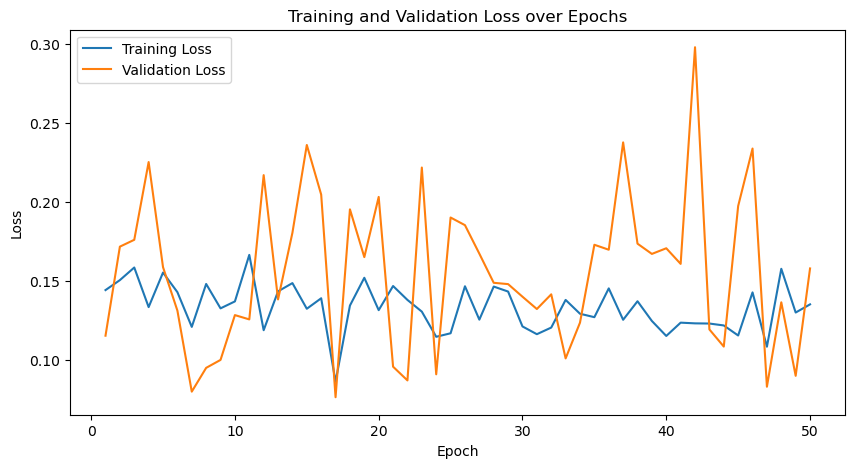

In [13]:
# 绘制训练和验证损失曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()